# Assesment 3: Concrete Crack Images for Classification

## 1. Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,callbacks,applications
import numpy as np
import matplotlib.pyplot as plt
import os,datetime

## 2. Data loading

In [2]:

directory_path = r'C:\Users\Farah\Desktop\HANDS-ON\deep_learning_sequential\capstone 3\Concrete Crack Images for Classification'

if os.path.exists(directory_path):
    print("Directory exists.")
else:
    print("Directory does not exist.")


Directory exists.


In [3]:
BATCH_SIZE=32
IMG_SIZE=(224,224)

In [4]:
data = keras.utils.image_dataset_from_directory(r'C:\Users\Farah\Desktop\HANDS-ON\deep_learning_sequential\capstone 3\Concrete Crack Images for Classification',
                                                batch_size=BATCH_SIZE,image_size=IMG_SIZE,shuffle=True)

Found 40000 files belonging to 2 classes.


In [32]:
#data_iterator = data.as_numpy_iterator()

In [33]:
#batch = data_iterator.next()

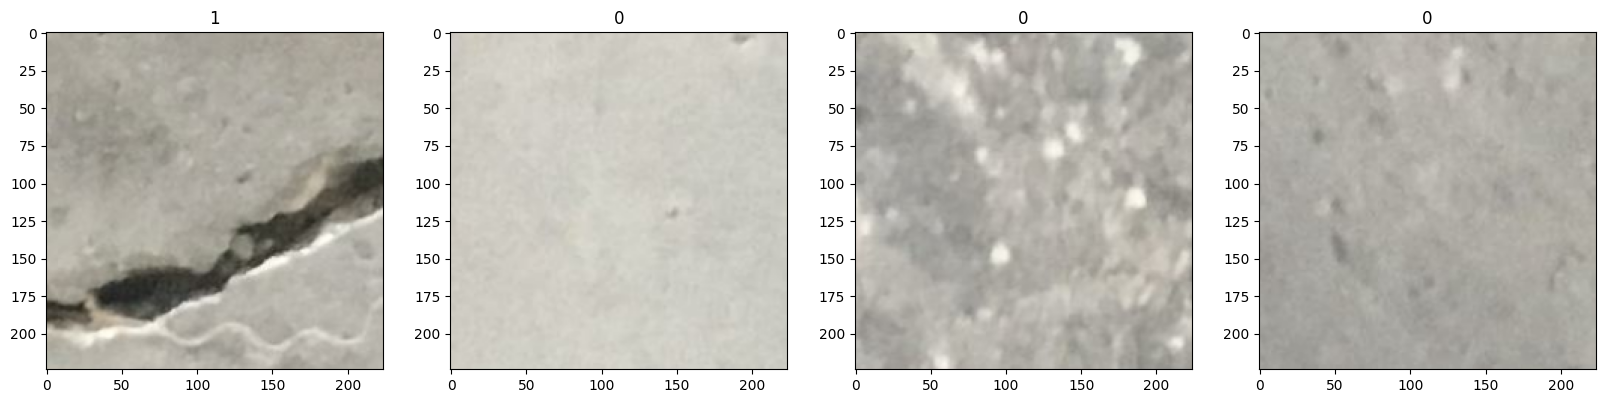

In [34]:
#fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#for idx, img in enumerate(batch[0][:4]):
    #ax[idx].imshow(img.astype(int))
    #ax[idx].title.set_text(batch[1][idx])

## 3. Scale Data

In [14]:
#data = data.map(lambda x,y: (x/255, y))

In [15]:
#data.as_numpy_iterator().next()

(array([[[[0.65882355, 0.6509804 , 0.654902  ],
          [0.6685892 , 0.66074604, 0.6646676 ],
          [0.68183213, 0.673989  , 0.67791057],
          ...,
          [0.6952282 , 0.69130665, 0.6756204 ],
          [0.69870555, 0.694784  , 0.6790977 ],
          [0.7019608 , 0.69803923, 0.68235296]],
 
         [[0.6555683 , 0.64772516, 0.65164673],
          [0.6653339 , 0.6574908 , 0.66141236],
          [0.6785769 , 0.67073375, 0.6746553 ],
          ...,
          [0.6691866 , 0.665265  , 0.64957875],
          [0.6726639 , 0.66874236, 0.6530561 ],
          [0.6759191 , 0.67199755, 0.6563113 ]],
 
         [[0.6605239 , 0.65268075, 0.6566023 ],
          [0.6702895 , 0.6624464 , 0.66636795],
          [0.6795027 , 0.6716596 , 0.67558116],
          ...,
          [0.6638557 , 0.6599341 , 0.64424783],
          [0.667333  , 0.66341144, 0.64772516],
          [0.67058825, 0.6666667 , 0.6509804 ]],
 
         ...,
 
         [[0.68235296, 0.6784314 , 0.6627451 ],
          [0.67258

## 4. Split Data

In [5]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) #for tuning parameters like number of hidden layers
test_size = int(len(data)*0.1) #solely for getting the performance of the model

In [6]:
train_dataset = data.take(train_size)
val_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size+val_size).take(test_size)

## 5. Data Inspection

In [7]:
# Extract the class names
class_names = data.class_names
print(class_names)

['Negative', 'Positive']


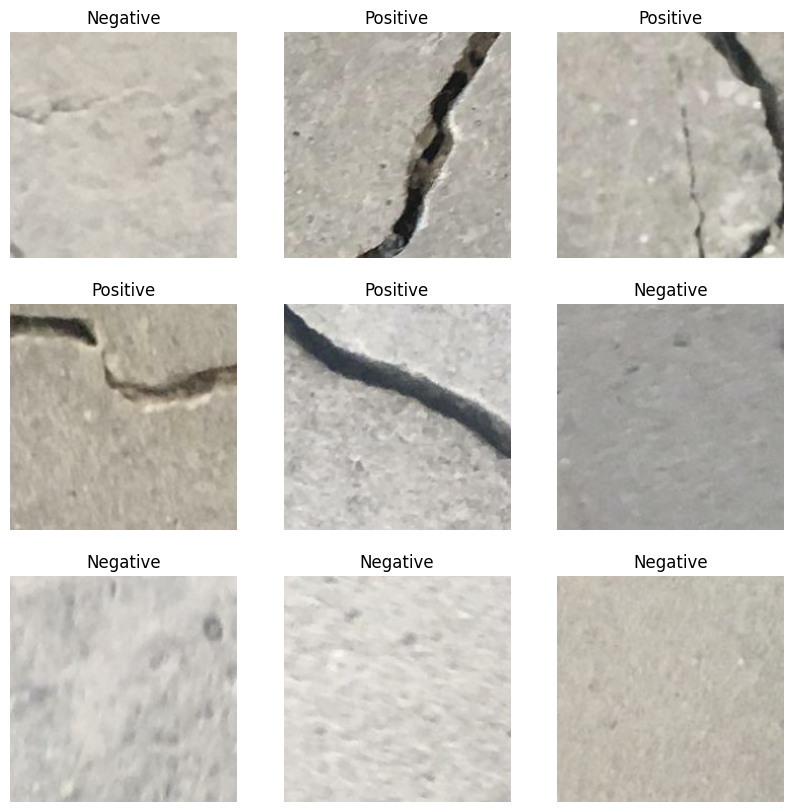

In [8]:
# Plot some examples
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

## 6. Splitting the val_dataset into Validation and Test Datasets

In [9]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)

## 7. Convert the Datasets into PrefetchDataset

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

pf_train = train_dataset.prefetch(buffer_size=AUTOTUNE)
pf_val = validation_dataset.prefetch(buffer_size=AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 8. Create a Keras Model for Data Augmentation
In the transfer learning tutorial, they included the preprocessing steps as layers within the Keras model.
There are two preprocessing steps that we can do (usually) for image data:
1. Data augmentation --> Helps to introduce more data variety into your datasets
2. Standardizing image pixel values --> Images might have different pixel format values, standardizing them will help preventing bias towards it.

In [11]:
data_augmentation = keras.Sequential(name='data_augmentation')
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.2))

## 9. Test out the Data Augmentation Model

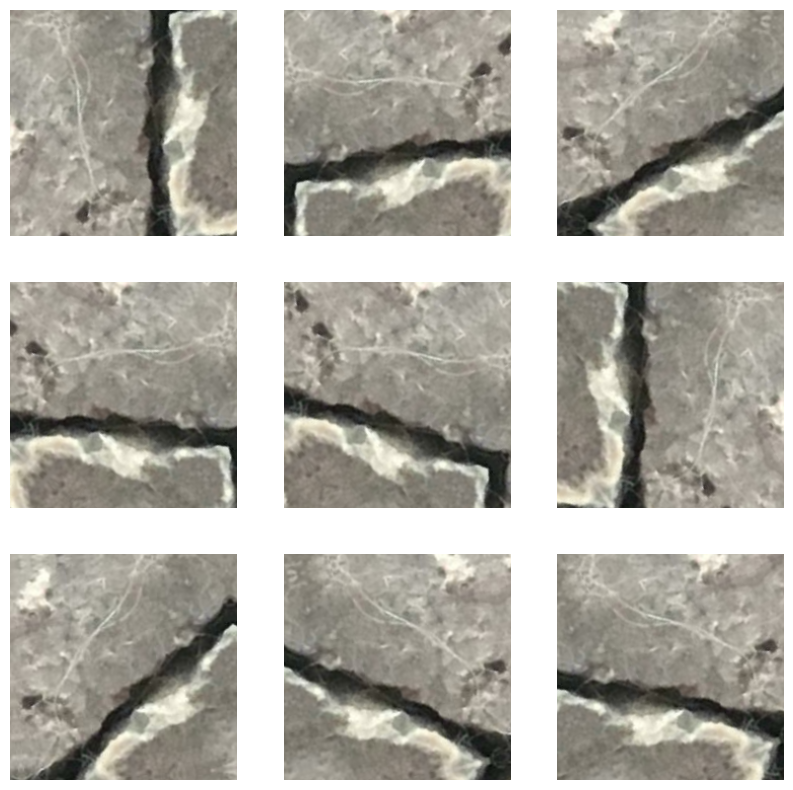

In [12]:
for images,labels in pf_train.take(1):
    first_image = images[0]
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        # Apply augmentation
        augmented_image = data_augmentation(tf.expand_dims(first_image,axis=0))
        plt.imshow(augmented_image[0]/255.0)
        plt.axis('off')
plt.show()

## 10. Create a Layer to Perform the Pixel Standardization

In [13]:
preprocess_input = applications.mobilenet_v2.preprocess_input

## 10. Start to Apply Transfer Learning

In [14]:
#(A) Get the pretrained model (only the feature extractor)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

In [15]:
#(B) Set the pretrained feature extractor as non-trainable (freezing)
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 7, 7, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 7, 7, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [16]:
#(C) Build our own classifier
# Create global average pooling layer
global_avg = layers.GlobalAveragePooling2D()
# Create output layer
output_layer = layers.Dense(len(class_names),activation='softmax')

In [17]:
#(D) Create the final model that contains the entire pipeline
#i. Input layer
inputs = keras.Input(shape=IMG_SHAPE)
#ii. Data augmentation model
x = data_augmentation(inputs)
#iii. Pixel standardization layer
x = preprocess_input(x)
#iv. Feature extraction layers
x = base_model(x,training=False)
#v. Global average pooling layer
x = global_avg(x) 
#vi. Output layer
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)

#(E) Instantiate the final model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                      

## 12. Compile the Model

In [18]:
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

## 13. Evaluate the Model Before Training

In [19]:
loss0, acc0 = model.evaluate(pf_test)
print("----------------------Evaluation before training-----------------------")
print("Loss = ",loss0)
print("Accuracy = ",acc0)

50/50 [==============================] - 1633s 6s/step - loss: 0.6694 - accuracy: 0.5881
----------------------Evaluation before training-----------------------
Loss =  0.6693798303604126
Accuracy =  0.5881249904632568


## 14. Create a TensorBoard Callback Object for the Usage of TensorBoard

In [20]:
base_log_path = r"tensorbaord_logs\capstone_3"
log_path = os.path.join(base_log_path,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_path)

In [ ]:
#from tensorflow import keras
#from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Define the early stopping callback
#early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


## 15. Model Training

In [ ]:
# Train your model with both callbacks
#EPOCHS = 10
#history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS,callbacks=[tb,early_stopping_callback])

In [21]:
EPOCHS = 3 #my laptop was very slow so i just put 3
history = model.fit(pf_train,validation_data=pf_val,epochs=EPOCHS,callbacks=[tb])

Epoch 1/3
875/875 [==============================] - 9572s 11s/step - loss: 0.0797 - accuracy: 0.9760 - val_loss: 0.0175 - val_accuracy: 0.9961
Epoch 2/3
875/875 [==============================] - 6765s 8s/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 0.0106 - val_accuracy: 0.9966
Epoch 3/3
875/875 [==============================] - 3518s 4s/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.0087 - val_accuracy: 0.9967


## 16. Proceed with the Follow-Up Training
Now, we proceed with the follow-up training, whereby we apply a different transfer learning strategy.
In this case, we are going to unfreeze some layers in the feature extractor so that they will receive parameter update.

In [22]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False #Freezing the first 100 layers
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

## 17. Recompile the Model

In [23]:
optimizer = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

## 18. Continue with the Model Training

In [24]:
fine_tune_epoch = 3
total_epoch = EPOCHS + fine_tune_epoch
# Follow-up training
history_fine = model.fit(pf_train,validation_data=pf_val,epochs=total_epoch,initial_epoch = history.epoch[-1],callbacks=[tb])

Epoch 3/6
875/875 [==============================] - 6881s 8s/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.0070 - val_accuracy: 0.9981
Epoch 4/6
875/875 [==============================] - 8704s 10s/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 0.0027 - val_accuracy: 0.9989
Epoch 5/6
875/875 [==============================] - 7071s 8s/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0023 - val_accuracy: 0.9992
Epoch 6/6
875/875 [==============================] - 8127s 9s/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0030 - val_accuracy: 0.9991


## 19. Evaluate the Final Transfer Learning Model

In [25]:
test_loss, test_accuracy = model.evaluate(pf_test)
print("--------------Evaluation after training-------------------")
print("Test loss = ",test_loss)
print("Test accuracy = ",test_accuracy)

50/50 [==============================] - 314s 4s/step - loss: 0.0044 - accuracy: 0.9975
--------------Evaluation after training-------------------
Test loss =  0.004395715892314911
Test accuracy =  0.9975000023841858


## 20. Model Deployment

In [26]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
y_pred = np.argmax(model.predict(image_batch),axis=1)
# Stack the label and prediction in one numpy array for comparison
label_vs_prediction = np.transpose(np.vstack((label_batch,y_pred)))

1/1 [==============================] - 9s 9s/step


## 21. Save the Model

In [27]:
save_path = os.path.join("save_model","capstone3_model.h5")
model.save(save_path)

In [28]:
import pickle
save_path = os.path.join("save_model", "capstone3_model.pkl")
# Save the model as a pickle file
with open(save_path, "wb") as file:
    pickle.dump(model, file)

In [29]:
#(Alternative) Save only the model parameters
save_weight_path = os.path.join("save_model","capstone3_model_weights.h5")
model.save_weights(save_weight_path)